<div style="text-align: center">
    <b> 
        <font size="6">
            IE582 - PROJECT REPORT 
        </font>
    </b>
</div>


<div style="text-align: right"> <i> Mert Sarıkaya, Ali Erdem Banak </i> </div>
<div style="text-align: right"> <i> 03-01-2020 </i> </div>




## 1) Introduction

Sports forecasting (specifically soccer, in this study) is important for the sports fans, the bookmakers, team managers, the media and the growing number of the bettors who bet on online platforms. We are given basically two types of information for predicting the outcomes of the matches. First data is related with bookmakers' odds, and second is related with matches and scores. Betting odds are one of the main sources of information in terms of predicting the soccer match outcome, since these odds are inherently projecting probabilistic beliefs of bookmakers. And lagged score brings additional information on how these teams are doing recently. 

In this project, we are aiming to predict English Premier League matches by using above mentioned data throughout 8 prediction period. In order to compare our predictions with bookmakers, we used ranked probability score metric. Details can be seen in approach part.

## 2) Related Literature

Sports betting is a popular area; therefore there are different approaches to the problem. While we knew that our model would be based on betting data and limited history of matches; we made ourselves familiar with the state-of-the-art models.

2018 World Cup was a playground for such models and most successful algorithms were belonged to KickOff.ai and FiveThirtyEight:

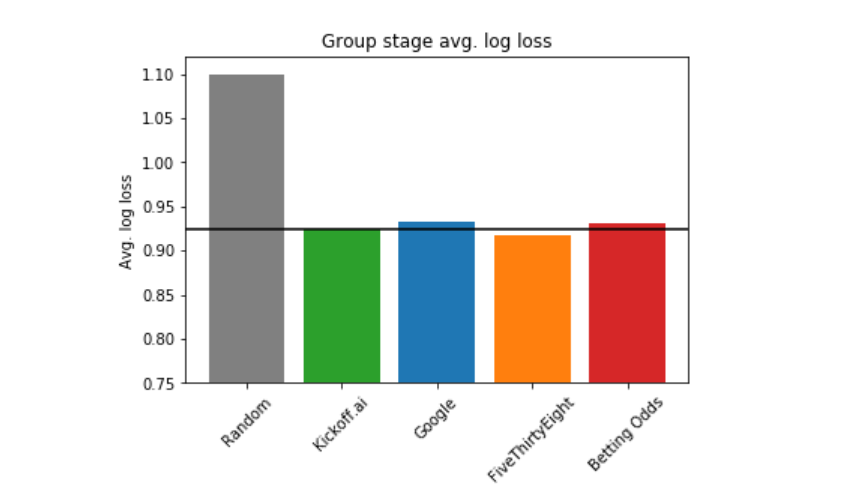

Predicting national games is quite different than predicting performance of club teams since there are less matches played by a national team. 

Both methods models the strength of teams with different approaches. Maystre (KickOff.AI) explicitly states the problem as "efficiently finding a ranking over a set of items" (Maystre). FiveThirtyEight also models the strength. In our models, we didn't account for the "name" of the team; but just recent - historic performance. FiveThirtyEight also uses importance of the match as a feature; which might have been used by us based on the position in the league in the end of the season kind of metrics.

https://infoscience.epfl.ch/record/255399

https://fivethirtyeight.com/features/how-our-2018-world-cup-predictions-work/

Another interesting feature FiveThirtyEight using was match ratings. They are using advanced stats (not just points - goals scored) but the expected score based on shots taken. They are modelling offensive and defensive ratings of two teams. Then assuming the goals scored is a Poisson process, they generate Poisson distributions based on the scores which would keep offensive rating same for a team. In the last step, they are generating matrix of all possible match scores and calculate the win/draw/loss probability.

## 3) Approach

## 3.1) Bookmaker Selection

Some bookmakers do not announce their odds for all of the matches, or they announce for some type of bets (like 1-0-2) but do not announce over-under bets, and these missing information is something that we do not want for our models. That is because many models does not work with the missing data, and filling those gaps usually is not preferred. Since there are 104 different bookmakers, we decided to remove the ones with the highest NA rates. We defined a function which mainly looks for the matches between a given start date and an end date, and takes a ratio which is the lower limit of NA percentage for a bookmaker. For example, 
```python
from helpers.bookmaker_selection import find_bookies_to_keep
bookies_to_keep = find_bookies_to_keep(start_date='2018-01-01', end_date='2019-12-01', ratio=0.95)
bookies_to_keep
# ['1xBet', 'SBOBET', 'bwin', 'William Hill', '888sport', 'Unibet', '18bet', 'Unibet.it', 'Chance.cz',
#  'BetVictor', 'Expekt', 'bet-at-home', 'Marathonbet', 'bet365.it', 'Betway', 'youwin', 'Tipsport.cz',
#  '10Bet', 'BoyleSports', 'Titanbet', 'Sportingbet', '188BET', 'Pinnacle', 'Betfred', 'iFortuna.cz',
#  'bet365', 'France Pari']
```
returns 27 bookmakers, whose NA ratio is less than 0.05 for the last 2 years. See [find_bookies_to_keep](https://github.com/sarikayamerts/ie582fall19/blob/63a012d65c7c3b239cc1d4262e0d1d28e21b81be/helpers/bookmaker_selection.py#L6) for details.

## 3.2) Feature Extraction

We decided to use two main dataframes, bets and matches. In bets data, we have different types of bets (like odd_2, u+2.5, o+4.5, odd_1x and so on, 65 different variables exist) and their odds for each matches and bookmakers. These odds are directly projects the probabilistic beliefs of bookmakers, after removing the margins of bookmakers, we can have the probabilities of each matches. In matches data, 



### *3.2.1) Bet Related Features*

There are 65 many different bet types but some of them has very little observations, and some of them do not bring any additional information with the presence of the ones who explain more info. The ones with the highest informations are 
```python
['odd_1', 'odd_x', 'odd_2'], 
['bts_yes', 'bts_no'], 
['o+1.5', 'u+1.5'],
['o+2.5', 'u+2.5'], 
['o+3.5', 'u+3.5'],
['o+4.5', 'u+4.5']
```
We are normalizing each line within themselves, after taking the inverse of odds for 'o+4.5' and 'u+4.5', we are normalizing them in a way that sum of two probabilities is 1, whereas for the 'odd_1', 'odd_x', 'odd_2' case, sum of 3 equals to 1. 

These odds are changing by time, therefore we decided to use their **first**, **last**, **min**, **max** and **mean** values for each of them. Even though we selected our bookmakers to the one which give less NA ratios, there are some matches that has very low number of odds that are announce for them, if this number (null ratio) is less than predefined threshold, we remove those matches, if there are some nulls less than threshold, we fill them with the mean values of related bet type. 

```python
from helpers.features import generate_bet_features
bets_df = generate_bet_features(bookies_to_keep, na_ratio=0.15)

[cols for cols in bets_df.columns if cols.startswith('1xBet')]
# ['1xBet_bts_no_first', '1xBet_bts_no_last', '1xBet_bts_no_max', 
#      '1xBet_bts_no_mean', '1xBet_bts_no_min',
#  '1xBet_bts_yes_first', '1xBet_bts_yes_last', '1xBet_bts_yes_max', 
#      '1xBet_bts_yes_mean', '1xBet_bts_yes_min',
#  '1xBet_o+1.5_first', '1xBet_o+1.5_last', '1xBet_o+1.5_max', '1xBet_o+1.5_mean', '1xBet_o+1.5_min',
#  '1xBet_o+2.5_first', '1xBet_o+2.5_last', '1xBet_o+2.5_max', '1xBet_o+2.5_mean','1xBet_o+2.5_min',
#  '1xBet_o+3.5_first', '1xBet_o+3.5_last', '1xBet_o+3.5_max', '1xBet_o+3.5_mean','1xBet_o+3.5_min',
#  '1xBet_o+4.5_first', '1xBet_o+4.5_last', '1xBet_o+4.5_max', '1xBet_o+4.5_mean', '1xBet_o+4.5_min',
#  '1xBet_odd_1_first', '1xBet_odd_1_last', '1xBet_odd_1_max', '1xBet_odd_1_mean', '1xBet_odd_1_min',
#  '1xBet_odd_2_first', '1xBet_odd_2_last', '1xBet_odd_2_max', '1xBet_odd_2_mean', '1xBet_odd_2_min',
#  '1xBet_odd_x_first', '1xBet_odd_x_last', '1xBet_odd_x_max', '1xBet_odd_x_mean', '1xBet_odd_x_min',
#  '1xBet_u+1.5_first','1xBet_u+1.5_last', '1xBet_u+1.5_max', '1xBet_u+1.5_mean','1xBet_u+1.5_min',
#  '1xBet_u+2.5_first', '1xBet_u+2.5_last', '1xBet_u+2.5_max', '1xBet_u+2.5_mean','1xBet_u+2.5_min',
#  '1xBet_u+3.5_first', '1xBet_u+3.5_last', '1xBet_u+3.5_max', '1xBet_u+3.5_mean','1xBet_u+3.5_min',
#  '1xBet_u+4.5_first', '1xBet_u+4.5_last', '1xBet_u+4.5_max', '1xBet_u+4.5_mean','1xBet_u+4.5_min']
```

As can be seen in code snippet above, for each bookmaker (for this case, 1xBet) 13 (for the bet type) * 5 (for the different statistics), total of 65 columns will be generated. 

See [generate_bet_features](https://github.com/sarikayamerts/ie582fall19/blob/63a012d65c7c3b239cc1d4262e0d1d28e21b81be/helpers/features.py#L7) for details.

### 3.2.2) *Match Scores Related Features*

In matches data, we have the scores for each match played. With these information we can create some lagged variables, like average goals scored for the last 5 matches, total point in this season, draw_ratio in this season and so on. We need to prepare this for the matches in train period, and we need to store match_ids in test period to work with them later on. Test period can be defined as matches between start_date and end_date in the example below. 

```python
from helpers.features import generate_match_features
matches_df, test_match_ids = generate_match_features(start_date='2019-12-20', end_date='2019-12-24')

test_matches
# [273274, 273273, 273277, 273272, 273276, 273271, 273275, 273279, 273278]

matches_df.columns
# ['match_id', 'point1_home', 'goal_scored1_home', 'goal_conceded1_home',
#  'total_goals1_home', 'point5_home', 'goal_scored5_home',
#  'goal_conceded5_home', 'clean_sheet5_home', 'over25_ratio5_home',
#  'under25_ratio5_home', 'total_goals5_home', 'point1_pos_home',
#  'goal_scored1_pos_home', 'goal_conceded1_pos_home',
#  'performance_season_home', 'draw_ratio_home', 'win_ratio_home',
#  'lost_ratio_home', 'over25_ratio_home', 'under25_ratio_home',
#  'draw_ratio_season_home', 'win_ratio_season_home',
#  'lost_ratio_season_home', 'over25_ratio_season_home',
#  'under25_ratio_season_home', 'draw_ratio_pos_home',
#  'win_ratio_pos_home', 'lost_ratio_pos_home',
#  'draw_ratio_season_pos_home', 'win_ratio_season_pos_home',
#  'lost_ratio_season_pos_home', 'over25_ratio_season_pos_home',
#  'under25_ratio_season_pos_home', 'point1_away', 'goal_scored1_away',
#  'goal_conceded1_away', 'total_goals1_away', 'point5_away',
#  'goal_scored5_away', 'goal_conceded5_away', 'clean_sheet5_away',
#  'over25_ratio5_away', 'under25_ratio5_away', 'total_goals5_away',
#  'point1_pos_away', 'goal_scored1_pos_away', 'goal_conceded1_pos_away',
#  'performance_season_away', 'draw_ratio_away', 'win_ratio_away',
#  'lost_ratio_away', 'over25_ratio_away', 'under25_ratio_away',
#  'draw_ratio_season_away', 'win_ratio_season_away',
#  'lost_ratio_season_away', 'over25_ratio_season_away',
#  'under25_ratio_season_away', 'draw_ratio_pos_away',
#  'win_ratio_pos_away', 'lost_ratio_pos_away',
#  'draw_ratio_season_pos_away', 'win_ratio_season_pos_away',
#  'lost_ratio_season_pos_away', 'over25_ratio_season_pos_away',
#  'under25_ratio_season_pos_away', 'point5_diff', 'point1_diff',
#  'performance_season_diff', 'exp_goal5', 'exp_goal1']
```

Since generated column names are self-exploratory, we will skip explain what are those. Details can be seen here [generate_match_features](https://github.com/sarikayamerts/ie582fall19/blob/63a012d65c7c3b239cc1d4262e0d1d28e21b81be/helpers/features.py#L70)

## 3.3) Feature Selection

Up to this point we have 10 (number of bookmakers to keep) * 65 (13*5, above) = 650 features for bet related features and 71 for match related features, which makes 721 feature total. This is huge, we need to reduce the dimensionality, we need to select the most important features.

For dimensionality reduction, we have used 2 steps. This was based on several trials between using PCA and PLS. First, we fit a random forest to the data with all the columns. Then, we are eliminating columns based on the SHAP values.

We decided to go with the SHAP values since it takes the average gain over permutations of columns. It provides us a better understanding of importance of a column.

https://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf

![title](Screenshot_20200103_151711.png)


## 3.4) Dimensionality Reduction

After this step, we still have around ~100 columns (cutting point was decided random; cutted from a point and checked the performance). After this point, we have used PLS. PLS is a linear transformation method, but while doing that it maximizes the covariance between response and predictors. We have tried PCA and PLS and decided to go with PLS for this step.

In deciding which method to use, we have checked cross-validation scores for logistic regression. One possible approach would be making this decision part of the grid search for all methods. 

## 3.5) Model Selection

We have tried different methods (LDA, SVM, ordinal regression, logistic regression, random forest, XGBOOST). XGBOOST had the highest performance with logistic regression coming second. We calculated performance based on the cross validation error.

In this part, we focused on over-fitting since there was a real difference between train error and cross-validation error, especially in tree based models. It is probably due to having not enough data.

We also tried using ensemble methods using mlens library. We ended up over-fitting, therefore we sticked on XGBOOST. Writing an ensemble method was another option. Train error for random forest and XGBOOST are quite lower than other methods. Therefore using a linear regression on train errors ended up with overfitting.

## 4) Results

## 5) Conclusions and Future Work

FiveThirtyEight proposes a completely different approach than us, which might have been interesting to explore. Even if we are not going that way; we might use "goals scored based on the shots taken" as an additional feature.

We might have used a stacked model based on other models. We tried using linear regression with features as outputs of other models; but ended up with a worse solution. During the process, we have tried different models and using them might have given us a better solution. This naturally depends on the covariance of the predictions; if the covariance is low, that would mean there is a chance of improving solution with a stacked model.

Also we should think about how we would be using cross-validation errors in stacking. Random forests and XGBOOST have significantly lower train error rate than logistic regression while their cross validation errors are closer.

## 6) Code

[GitHub Repo](https://github.com/sarikayamerts/ie582fall19)
